<font size="6">Text Mining com Python e Whoosh: Cartas Brasileiras (PHPB-Ba)</font>

<p><font size="5" color="darkred">Valter Moreno</font></p>

<font size="3" color="gray">**Fundação Getúlio Vargas (FGV)**<br/>
**Mestrado em Matemática Aplicada (EMAp)**<br/>
**Sistemas de Recuperação de Informação - 2019**<br/></font>

<font size="4" id="tocheading">Índice</font>
<div id="toc"></div>
<br>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Objetivos do projeto

Neste projeto, analisamos os manuscritos modernizados do Corpus Eletrônico de Documentos Históricos do Sertão [(CE-DOHS)](http://www.tycho.iel.unicamp.br/cedohs/corpora.html) com os seguintes objetivos:

  - identificar os principais assuntos tratados nos documentos; e
  - avaliar semanticamente o seu conteúdo, ou seja, o significado das palavras de seu vocabulário.
  
Além de obtermos resultados globais para todo o corpus, dividimos os documentos de acordo com as décadas de sua produção, de forma a avaliar mudanças em assuntos e no significado de palavras ao longo do tempo.  

## Corpus analisado

O Corpus Compartilhado Diacrônico – Cartas Brasileiras (PHPB-Ba) é disponibilizado no website do projeto Plataforma Corpus Eletrônico de Documentos Históricos do Sertão [CE-DOHS]. O projeto é coordenado por Zenaide de Oliveira Novais Carneiro (UEFS/Fapesb/CNPq) e Mariana Fagundes de Oliveira Lacerda (UEFS/Fapesb).

O corpus analisado neste projeto consiste de 1.185 cartas com datas no período de 1823 a 2000. As cartas provêm de 14 corporas distintos, listados no [website do CE-DOHS](http://www.tycho.iel.unicamp.br/cedohs/corpora.html).

## Software utilizado

In [2]:
import numpy as np
import os
import glob
import re

import pandas as pd
pd.set_option('precision', 5)
pd.set_option('display.max_colwidth', -1) # Customização do display de dataframes para que
                                          # todo o conteúdo das colunas seja mostrado
import matplotlib.pyplot as plt
%config InteractiveShellApp.pylab_import_all = False
%pylab inline

import seaborn as sb
sb.set(palette='dark', color_codes=True)

from collections import defaultdict, Counter
from datetime import datetime
from pprint import pprint

# Gensim
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
#from gensim.models import CoherenceModel

# spaCy
import spacy
nlp = spacy.load("pt_core_news_sm")

# NLTK
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
#import nltk
#from nltk.tokenize import WordPunctTokenizer
#from nltk.stem.snowball import PortugueseStemmer

#import string
#from string import punctuation
#from itertools import islice
#from numpy.linalg import norm

#from spellchecker import SpellChecker

#import spacy
#nlp = spacy.load("pt_core_news_sm")


#from whoosh.index import create_in, open_dir
#from whoosh.fields import *
#from whoosh.analysis import RegexTokenizer, LanguageAnalyzer, StopFilter, LowercaseFilter, StemFilter
#from whoosh.qparser import QueryParser
#from whoosh.query import Phrase

# Avisos:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

Populating the interactive namespace from numpy and matplotlib


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vmoreno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Função para a impressão de conteúdo Markdown
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

## Importação dos textos do corpus

O corpus de 1.185 cartas está dividido em arquivos de texto com o conteúdo original e modernizado.  Em nossa análise, utilizamos apenas as cartas com o português modernizado. Um exemplo de manuscrito modernizado é mostrado a seguir.

In [4]:
caminho = "CE-DOHS/*.txt"
arquivos  = glob.glob(caminho)
printmd('**Há um total de <font color="gray">' + str(len(arquivos)) + '</font> arquivos no diretório do corpus.**\n')
printmd('**Nomes dos primeiros arquivos:**')
for i in range(0,8):
    print(arquivos[i])

**Há um total de <font color="gray">2370</font> arquivos no diretório do corpus.**


**Nomes dos primeiros arquivos:**

CE-DOHS/01-AAD-17-04-1962-mod.txt
CE-DOHS/01-AAD-17-04-1962-orig.txt
CE-DOHS/01-ACST-14-01-1952-mod.txt
CE-DOHS/01-ACST-14-01-1952-orig.txt
CE-DOHS/01-AFS-28-04-1956-mod.txt
CE-DOHS/01-AFS-28-04-1956-orig.txt
CE-DOHS/01-APACA-14-01-1980-mod.txt
CE-DOHS/01-APACA-14-01-1980-orig.txt


In [5]:
arquivos = [id for id in arquivos if id.endswith('-mod.txt')]

In [6]:
printmd('**<br/>Conteúdo do primeiro arquivo com português modernizado:**')
with open(arquivos[0]) as f:
    texto = [linha.strip(' \n') for linha in f.readlines() if len(linha.strip(' \n')) > 0] 
pd.DataFrame(texto, columns=['']).style.set_properties(**{'text-align': 'left'})

**<br/>Conteúdo do primeiro arquivo com português modernizado:**

,
0,|:| Corpus Eletrônico de Documento Históricos do Sertão [ CE-DOHS ]
1,|:| Bruna Trindade
2,|:| Carta 01-AAD-17-04-1962
3,|:| Autor: Arnaldo Andrade Dias (apócrifo)
4,|:| Destinatário: Maria de Lourdes de Lima Oliveira
5,|:| Data: 17/04/ 1962
6,|:| Versão modernizada
7,|:| Encoding: UTF-8
8,Carta 1
9,APFFO . 1 de 23 . Documento contendo um fólio . Papel almaço com pautas .


## Extração de metadados e texto dos arquivos

Os arquivos do CE-DOHS incluem metadados em seu cabeçalho identificados pela sequência de caracteres `|:|`. Os seguintes campos são fornecidos:

  * Identificação do corpus
  * Nome da pesqisadora  
  * Identificação da carta
  * Nome do autor da carta
  * Nome do destinatário
  * Data da carta
  * Identificação de carta modernizada
  * Identificação da codificação (UTF-8)
  * Número da carta
  * Descrição do manuscrito (ex., local de arquivo, tipo de papel)

In [7]:
printmd('**Metadados do primeiro arquivo:**')
pprint([meta for meta in texto if meta.startswith('|:|')])

**Metadados do primeiro arquivo:**

['|:| Corpus Eletrônico de Documento Históricos do Sertão [ CE-DOHS ]',
 '|:| Bruna Trindade',
 '|:| Carta 01-AAD-17-04-1962',
 '|:| Autor: Arnaldo Andrade Dias (apócrifo)',
 '|:| Destinatário: Maria de Lourdes de Lima Oliveira',
 '|:| Data: 17/04/ 1962',
 '|:| Versão modernizada',
 '|:| Encoding: UTF-8']


Para otimizar o uso da memória do computador, criamos uma classe que, quando instanciada, processa os documentos do corpus iterativamente, extraindo os metadados e gravando o texto processado num novo arquivo. O texto de cada carta foi processado da seguinte forma:

  * removemos espaços desnecessários dos nomes dos remetentes e destinatários; 
  * tranformamos as cadeias de caracter das datas originais em datas;
  * removemos o cabeçalho, com os metadados do arquivo; parte deles foi aproveitada para preencher os valores de identificação da carta, autor, destinatário, e data;
  * removemos o texto explicativo geralmente adicionado a cada carta, com informações tais como o tipo de papel usado, o número de folhas, onde a carta estava guardada, etc.
  * removemos notas inseridas no manuscrito para identificar mudanças de página, rasuras, borrados, etc.
  * removemos notas de rodapé, tipicamente explicando que anotações foram feitas no manuscrito
  * separamos trechos demarcados por quebras de linha e pontuações (ponto final, de exclação e de interrogação, ponto e vírgula, e travessão) em linhas. 

In [8]:
class CartasCorpus:
    def __init__(self, arquivos, pasta, ndocs=100, inicio=10):
        self.arquivos = arquivos
        self.pasta = pasta
        self.ndocs = min(len(arquivos),ndocs)
        self.inicio = inicio
    '''
    Para cada os ndocs primeiros arquivos do corpus, os metadados são extraídos e adicionados
    ao dataframe passado na criação do objeto. Além disso, o conteúdo do arquivo é processado 
    de acordo com o tipo de processamento especificado, e gravado num arquivo com o mesmo ID do
    arquivo original e o sufixo "-proc.txt".
    '''    
    def __iter__(self):
        for fileid in self.arquivos[:self.ndocs]:
            meta_dic = dict()            
            
            ''' Lê o conteúdo do arquivo numa lista de linhas:
            '''
            with open(fileid, mode="r", encoding="utf-8") as doc:
                linhas = [linha.strip(' \n') for linha in doc.readlines() if len(linha.strip(' \n')) > 0]
                
            ''' Cria um dicionário a partir das linhas de metadados:
            '''
            meta_dic['ID'] = fileid.replace('CE-DOHS/','').replace('-mod.txt','')
            
            rem = [autor.replace(u'|:| Autor:', '').strip(' .') \
                   for autor in linhas \
                   if u'|:| Autor:' in autor][0]
            meta_dic['Remetente'] = rem if len(rem) > 0 else np.NaN
            
            dest = [dest.replace(u'|:| Destinatário:', '').strip(' .') \
                    for dest in linhas \
                    if u'|:| Destinatário:' in dest][0]
            meta_dic['Destinatário'] = dest if len(dest) > 0 else np.NaN
            
            ''' Tenta obter a data da carta:
            '''
            data = [data.replace(u'|:| Data:', '').strip(' .').lower() \
                    for data in linhas \
                    if u'|:| Data:' in data][0]
            meses = ['janeiro','fevereiro','mar','abril','maio','junho',
                     'julho','agosto','setembro','outubro','novembro','dezembro'] 
            mes = [mes for mes in meses if mes in data]
            if mes:
                data = data.replace(mes[0], '/' + str(meses.index(mes[0]) + 1) + '/')
            data_num = re.compile('[0-9\/]')
            data = data_num.findall(data)
            data = ''.join(data)
            try:
                data_dt = pd.to_datetime(data, infer_datetime_format=True)
                if pd.isna(data_dt) or data_dt.year > 2000 or data_dt.year < 1823:
                    data = self.data_id(fileid)
                else:
                    data = data_dt.strftime("%d/%m/%Y")
            except:
                data = self.data_id(fileid)
            meta_dic['Data'] = data
                
            ''' Processa as linhas e retorna uma nova lista com elementos do
                tipo especificado:
            '''
            texto = self.proc_texto(linhas, self.inicio)
                
            ''' Grava o arquivo com o texto processado no diretório 'CE-DOHS-proc/':
            '''
            if not os.path.exists(self.pasta):
                os.makedirs(self.pasta)
                
            nome = self.pasta + meta_dic['ID'] + '-proc.txt'
            with open(nome,'w+') as arquivo:
                arquivo.writelines("%s\n" % linha for linha in texto)                    
                
            yield meta_dic
                    
    def data_id(self, fileid):
        '''
        No corpus Corpus Eletrônico de Documentos Históricos do Sertão, a maior parte dos
        nomes dos arquivos inclui a data da carta. Esta função tenta recuperar essa data 
        a partir do nome do arquivo. O resultado gerado é um objeto to tipo datetime ou NaN.
        '''
        data_num = re.compile('[0-9]{2}-[0-9]{2}-[0-9]{4}')
        data = data_num.findall(fileid)
        if data:
            try:
                data_dt = pd.to_datetime(data[0], format='%d-%m-%Y')
                if pd.isna(data_dt):
                    return np.NaN
                else:
                    return data_dt.strftime("%d/%m/%Y") 
            except:
                return np.NaN
        else:
            return np.NaN

    def proc_texto(self, linhas, inicio):
        '''
        Processa cada linha do conteúdo do documento, a partir da linha de inicial passada (inicio),
        de acordo com o tipo de processamento especificado. Retorna uma lista com os resultados.
        '''
        ''' Converte as linhas do texto num único string:
        '''
        texto = linhas[inicio:len(linhas)]
        texto = '\n'.join(texto)
        
        ''' Elimina caracteres e comentários indesejáveis:
        '''
        texto = texto.replace('[pag]', '')
        texto = re.sub('\[footer:([\\n a-zA-Z0-9áàâãéèêíïóôõöúçñÁÀÂÃÉÈÍÏÓÔÕÖÚÇÑ.,!?;:<>()-_#\'\"‘’“”]*)\]',
                                 '', texto)
        texto = re.sub('\[header:[ ]*\]', '\n', texto)
        texto = re.sub('[|]*[ ]*[Ff]l. [0-9] [rv]', ' ', texto)
        texto = re.sub('[0-9][ ]*Rasura[do]*[ .]*', ' ', texto)
        texto = re.sub('[0-9][ ]*Borrado[ .]*', ' ', texto)
        texto = re.sub('\[[ ]*[Rr]ubrica[ ]*\]', ' ', texto)
        texto = re.sub('\[[ ]*[Rr]asura[ ]*\]', ' ', texto)
        texto = re.sub('\[[ ]*[Ii]nint[ ]*.[ ]*\]', ' ', texto)
        texto = texto.strip()
        
        linhas = [linha for linha in texto.split('\n') if len(linha) > 0]
        linhas = self.quebra_linhas(linhas, ['?', '!', '.', ';', '–'])
        
        return linhas
    
    def quebra_linhas(self, linhas, pontos):
        for ponto in pontos:
            novas = []
            for linha in linhas:
                if ponto in linha:
                    novas.extend([l.strip('[]-,:‘’“”\'\" ') for l in linha.split(ponto) if len(l) > 0])
                else:
                    if len(linha) > 0:
                        novas.extend([linha])
            linhas = novas
        return novas


Instanciamos a classe criando um objeto que se comporta como um iterador. O processamento dos textos do corpus só é efetivamente realizado ao longo das iterações do *loop* `for doc in dic:` no trecho de código a seguir.

In [9]:
metadados = pd.DataFrame(columns=['ID', 'Remetente', 'Destinatário', 'Data'])

dic = CartasCorpus(arquivos, 'CE-DOHS-proc/', ndocs=10000)

for doc in dic:
    metadados = metadados.append(doc, ignore_index=True)

Abaixo, motramos o dataframe com os resultados da extração dos metadados dos textos do corpus.

In [10]:
metadados

,ID,Remetente,Destinatário,Data
0,01-AAD-17-04-1962,Arnaldo Andrade Dias (apócrifo),Maria de Lourdes de Lima Oliveira,17/04/1962
1,01-ACST-14-01-1952,Antonio Carneiro da Silva Tuy,Maria de Souza Estrela,14/01/1952
2,01-AFS-28-04-1956,Antonio Fortunato da Silva,João Carneiro de Oliveira,28/04/1956
3,01-APACA-14-01-1980,Adelmário Carneiro de Araújo,Eliana de Oliveira Lima,14/01/1980
4,01-ASA-14-05-1955,Acioly Silva Araújo,Dantas Junior,14/05/1955
...,...,...,...,...
1180,98-VOV-28-11-1934,Virginia Ottoni Vieira,Yáyá,28/11/1934
1181,99-AJN-26-05-1878,Antonio Jose Nogueira,Doutor Martim Francisco Ribeiro de Andrade,26/05/1878
1182,99-DCO,Doralice Carneiro de Oliveira Jesus,Zenilta Bispo de Oliveira,NaN
1183,99-HRS-01-01-1931,Hermínio Reis [Silva],Dantas Junior,01/01/1931


O conteúdo processado do primeiro arquivo é exibido a seguir.

In [11]:
fileid = 'CE-DOHS-proc/' + metadados.ID[0] + '-proc.txt'
with open(fileid, mode="r", encoding="utf-8") as doc:
    linhas = [linha.strip('\n') for linha in doc.readlines()]
pprint(linhas)

['São Paulo 17 de abril 1962',
 'Inesquicível Lurdes',
 'Adeus ao longe ,',
 'Em uma tarde tristonho , cheio de saudade , que peguei em minha rude caneta '
 'para te escrever dando as minhas notícias , que 1 de saúde vou bem só o que '
 'me mata 2 é a cruel se 3 lembrança de você',
 'Talvez você não acredite meu amor mais quando chega 4 o domingo fico na '
 'impressão que a tarde vou te ver e a inda mais aumenta o meu sofrer pois já '
 'estou arrependido da hora que me ausentei de lá',
 'Embora já sabia que não suportava viver ausente de te meu amor , tentei só '
 'para sofrer , parece-me que tu és a única pessoa que Deus deixou para eu '
 'amar com todo amor que meu jovem coração encerra',
 'Sem mais abraços fortes para você e aceite mil recordações',
 'deste que te ama sem falsidade até o fim , do seu amor que muito te quer',
 'Arnaldo Andrade Dias']


## Análise exploratória dos metadados

### Número de cartas por ano

Uma vez que desejávamos avaliar as diferenças entre tópicos e significados de palavras ao longo tempo, era importante avaliar como os textos analisados estavam distribuídos ao longo do período compreendido no corpus (1823-2000). O gráfico a seguir mostra a evolução do número de cartas disponíveis em cada ano desse período. 

In [12]:
anos = [data[-4:] if not pd.isnull(data) else np.nan for data in metadados.Data.tolist()]
anos = [int(ano) if not pd.isnull(ano) else np.nan for ano in anos]
freq = pd.DataFrame(Counter(anos).items(), columns=['Ano','Frequência']).sort_values(by='Ano')

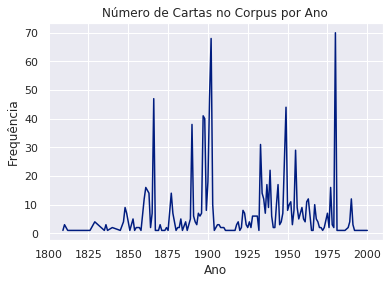

In [13]:
ax = sb.lineplot(x='Ano', y='Frequência', data=freq)
ax.set_title('Número de Cartas no Corpus por Ano')
plt.show()

O gráfico acima mostra diferenças substanciais no número de documentos por ano. Além disso, na maior parte dos anos, a frequência é inferior a 30 documentos. Antevendo a necessidade de treinamento dos modelos usados nas análises posteriores, decidimos avaliar possibilidades de agregação por intervalo de tempo (ex., 10 em 10 anos, 20 em 20, etc.). Os resultados para algumas alternativas são apresentados nos próximos gráficos.

In [14]:
def bar_periodo(dados, inicio=1823, periodo=10, fim=2000):
    freq_dic = dict()
    freq_dic[inicio] = freq.loc[[ano <= inicio \
                                 if not pd.isnull(ano) else False \
                                 for ano in freq.Ano]]['Frequência'].sum()
    for decada in range(inicio, fim, periodo):
        limite = decada + periodo if decada + periodo < fim else 2000
        freq_dic[limite] = freq.loc[[(ano > decada and ano <= limite) \
                                               if not pd.isnull(ano) else False \
                                               for ano in freq.Ano]]['Frequência'].sum()
    freq_periodo = pd.DataFrame(columns=['Ano', 'Frequência'])
    freq_periodo.Ano = freq_dic.keys()
    freq_periodo.Frequência = freq_dic.values()
    ax = sb.barplot(x='Ano', y='Frequência', data=freq_periodo)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_title('Número de Cartas por Período')
    plt.show()

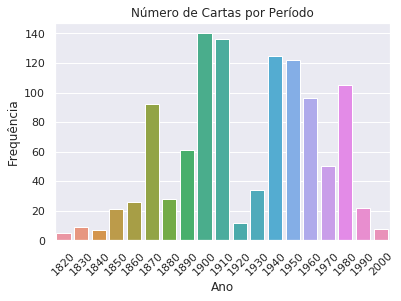

In [15]:
bar_periodo(freq, 1820, 10, 2000)

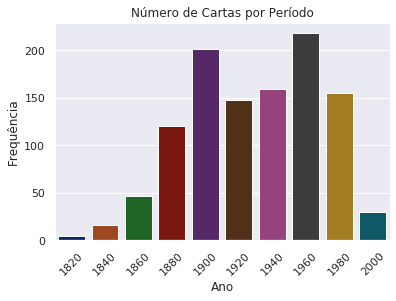

In [16]:
bar_periodo(freq, 1820, 20, 2000)

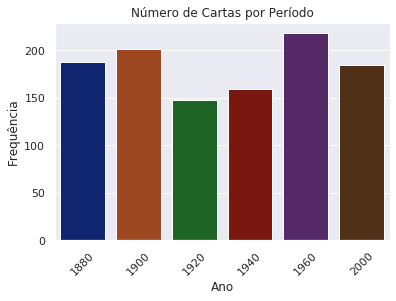

In [17]:
bar_periodo(freq, 1880, 20, 1980)

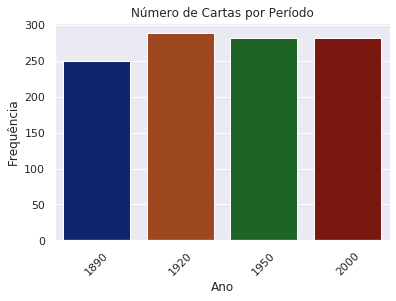

In [18]:
bar_periodo(freq, 1890, 30, 1980)

A opção de agrupamento acima é bem equilibrada em termos de número de documentos por período (entre 250 e 300 cartas). Além disso, inclui um número de faixas suficiente para representar períodos importantes da história brasileira:

  - **1823-1890**: Império
  - **1890-1920**: início da República
  - **1920-1950**: era Vargas, Segunda Grande Guerra, Juscelino Kubitschek
  - **1950-2000**: ditadura e democratização
  
Esses períodos foram adotados na análise longitudinal de tópicos e significados, descrita posteriormente.

### Remetentes e destinatários

Os metadados coletados incluem informações do remetente e do destinatário de uma carta. Verificamos que o número de remetentes únicos é bastante superior ao de destinatários. Além disso, ambos representam percentuais relativamente baixos do total de cartas do corpus. Logo, há mais de uma carta de um mesmo remetente, e várias cartas para um mesmo destinatário.

In [19]:
remetentes = len(metadados.Remetente.unique())
destinatarios = len(metadados.Destinatário.unique())
n_cartas = metadados.shape[0]

printmd('**Número de remetentes únicos no corpus: <font color="gray">' + 
        str(remetentes) + ' (' + str(round(100*remetentes/n_cartas, 2)) + '%)</font>**')
printmd('**Número de destinatários únicos no corpus: <font color="gray">' + 
        str(destinatarios) + ' (' + 
        str(round(100*destinatarios/n_cartas, 2)) + '%)</font>**')

**Número de remetentes únicos no corpus: <font color="gray">555 (46.84%)</font>**

**Número de destinatários únicos no corpus: <font color="gray">234 (19.75%)</font>**

O histograma do número de cartas de cada remetente indica que a vasta maioria dos remetentes escreveu menos de 10 cartas. Em torno de 3.2% dos remententes no corpus foram autores de mais de 10 documentos.

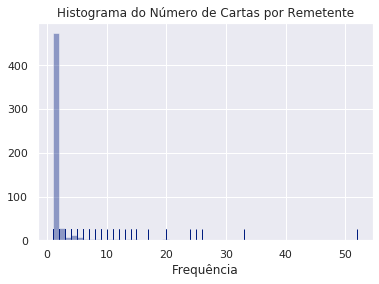

In [20]:
freq_rem = pd.DataFrame(Counter(metadados.Remetente).items(), 
                        columns=['Remetente', 'Frequência'])\
             .sort_values(by=['Frequência'], ascending=False)

ax = sb.distplot(freq_rem.Frequência, kde=False, rug=True)
ax.set_title('Histograma do Número de Cartas por Remetente')
plt.show()

In [21]:
n_rem = len(freq_rem.loc[freq_rem.Frequência > 10])

printmd('**Número de remetentes com mais de 10 cartas no corpus: <font color="gray">' + 
        str(n_rem) + ' (' + str(round(100*n_rem/remetentes, 2)) + '%)</font>**')

**Número de remetentes com mais de 10 cartas no corpus: <font color="gray">18 (3.24%)</font>**

In [22]:
printmd('<br/>**Remetentes de mais de 10 cartas:**')
freq_rem.loc[freq_rem.Frequência > 10]

<br/>**Remetentes de mais de 10 cartas:**

,Remetente,Frequência
266,Aracy Leonardo Pereira,52
8,João Pinto Leite,33
2,Antonio Fortunato da Silva,26
5,Antonia Thereza Wanderley,25
144,Benicio Penalva de Faria (B. Penalva),24
262,Francisco Mendes da Rocha,20
0,Arnaldo Andrade Dias (apócrifo),20
41,F. Octaviano [Francisco Octaviano de Almeida Rosa],17
11,Renée da Silva Barros Soledade,15
17,Otto Soledade Júnior,15


Da mesma forma, vemos que poucas pessoas foram destinatárias de mais de 10 cartas. 

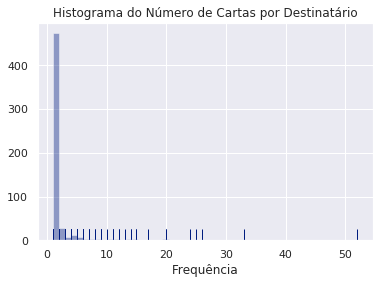

In [23]:
freq_dest = pd.DataFrame(Counter(metadados.Remetente).items(), 
                        columns=['Destinatário', 'Frequência'])\
             .sort_values(by=['Frequência'], ascending=False)

ax = sb.distplot(freq_dest.Frequência, kde=False, rug=True)
ax.set_title('Histograma do Número de Cartas por Destinatário')
plt.show()

In [24]:
n_dest = len(freq_dest.loc[freq_dest.Frequência > 10])

printmd('**Número de destinatários com mais de 10 cartas no corpus: <font color="gray">' + 
        str(n_dest) + ' (' + 
        str(round(100*n_dest/destinatarios, 2)) + '%)</font>**')

**Número de destinatários com mais de 10 cartas no corpus: <font color="gray">18 (7.69%)</font>**

In [25]:
printmd('<br/>**Destinatários de mais de 10 cartas:**')
freq_dest.loc[freq_dest.Frequência > 10]

<br/>**Destinatários de mais de 10 cartas:**

,Destinatário,Frequência
266,Aracy Leonardo Pereira,52
8,João Pinto Leite,33
2,Antonio Fortunato da Silva,26
5,Antonia Thereza Wanderley,25
144,Benicio Penalva de Faria (B. Penalva),24
262,Francisco Mendes da Rocha,20
0,Arnaldo Andrade Dias (apócrifo),20
41,F. Octaviano [Francisco Octaviano de Almeida Rosa],17
11,Renée da Silva Barros Soledade,15
17,Otto Soledade Júnior,15


## Modelagem de tópicos

Para a modelagem de tópicos do corpus, utilizamos o algoritmo de Indexação Semântica Latente [(Latent Semantic Indexing - LSI)](https://en.wikipedia.org/wiki/Latent_semantic_analysis) da biblioteca [gensim](https://radimrehurek.com/gensim/). 

O primeiro passo foi tokenizar e lematizar os textos, remover *stop words*, e criar um corpus com as classes do gensim: 
  - A tokenização foi feita com o método `tokenize()` do próprio gensim (https://radimrehurek.com/gensim/utils.html#gensim.utils.tokenize). 
  - A deleção de *stop words* foi feita com base numa lista obtida da união das palavras disponíveis nas biblotecas [spaCy](https://spacy.io/usage/spacy-101) e [nltk](http://www.nltk.org/), complementada com pronomes de tratamento (ex., Excelentíssimo, Vossa Excelência, etc.) e com as palavras da lista capitalizadas. 
  - Há poucas alternaticas para implementar a lematização na língua portuguesa, todas com performance ainda abaixo das opções para a língua inglesa (https://lars76.github.io/nlp/lemmatize-portuguese/). Optamos por realizar a lematização com a biblioteca spaCy (https://spacy.io/api/lemmatizer).

Como feito antes, para otimizar o uso da memória, criamos uma classe que implementa um iterador. Quando objeto da classe é iterado, o conteúdo tokenizado de um arquivo com o conteúdo processado de uma carta é alimentado ao corpus e ao dicionário do gensim. O corpus utiliza o modelo [bag of words](https://radimrehurek.com/gensim/auto_examples/core/run_core_concepts.html).

**Criação do conjunto de *stop words*:**

In [51]:
spacy_stopwords = spacy.lang.pt.stop_words.STOP_WORDS
printmd('**Número de *stop words* em português no spaCy: <font color="gray">' + str(len(spacy_stopwords)) + 
        '</font>**')
printmd('**Primeiros *stop words* na lista:**')
print(sorted(list(spacy_stopwords))[:20])

**Número de *stop words* em português no spaCy: <font color="gray">413</font>**

**Primeiros *stop words* na lista:**

['acerca', 'ademais', 'adeus', 'agora', 'ainda', 'algo', 'algumas', 'alguns', 'ali', 'além', 'ambas', 'ambos', 'antes', 'ao', 'aos', 'apenas', 'apoia', 'apoio', 'apontar', 'após']


In [52]:
nltk_stopwords = sorted(nltk.corpus.stopwords.words('portuguese'))
printmd('**Número de *stop words* em português no nlkt: <font color="gray">' + str(len(nltk_stopwords)) + 
        '</font>**')
printmd('**Primeiros *stop words* na lista:**')
print(nltk_stopwords[:20])

**Número de *stop words* em português no nlkt: <font color="gray">204</font>**

**Primeiros *stop words* na lista:**

['a', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois']


In [63]:
pron_tratamento = {'você', 'Sr', 'Sra', 'Srta', 'senhor', 'senhora', 'senhorita', 'vosmecê', 'V', 'Sa', 
                   'Vossa', 'Senhoria', 'Exa', 'Excelência', 'Ema', 'Eminência', 'S', 'Santidade', 'Rev', 
                   'Reverendíssima', 'Alteza', 'M', 'Majestade', 'M', 'Magnificência',
                   'Excelentíssimo', 'Excelentíssima', 'Excelentíssimos', 'Excelentíssimas'}

stopwords = set(spacy_stopwords).union(set(nltk_stopwords))

stopwords = stopwords\
              .union(set([word.capitalize() for word in list(stopwords)]))\
              .union(pron_tratamento)

printmd('**Número de *stop words* nas duas bibliotecas: <font color="gray">' + str(len(stopwords)) + 
        '</font>**')
printmd('**Primeiros *stop words* na lista:**')
print(sorted(list(stopwords))[:50])

with open('stopwords.txt', 'w+') as file:
    file.writelines("%s\n" % word for word in sorted(list(stopwords)))

**Número de *stop words* nas duas bibliotecas: <font color="gray">1024</font>**

**Primeiros *stop words* na lista:**

['A', 'Acerca', 'Ademais', 'Adeus', 'Agora', 'Ainda', 'Algo', 'Algumas', 'Alguns', 'Ali', 'Alteza', 'Além', 'Ambas', 'Ambos', 'Antes', 'Ao', 'Aos', 'Apenas', 'Apoia', 'Apoio', 'Apontar', 'Após', 'Aquela', 'Aquelas', 'Aquele', 'Aqueles', 'Aqui', 'Aquilo', 'As', 'Assim', 'Através', 'Atrás', 'Até', 'Aí', 'Baixo', 'Bastante', 'Bem', 'Boa', 'Bom', 'Breve', 'Cada', 'Caminho', 'Catorze', 'Cedo', 'Cento', 'Certamente', 'Certeza', 'Cima', 'Cinco', 'Coisa']


**Definição da classe para a criação de corpus no gemsin:**

In [64]:
class GensimCorpus:
    def __init__(self, pasta, IDs, sufixo, dicionario, stop_words, lower=True, lema=False, nomes=False):
        self.pasta = pasta
        self.IDs = IDs
        self.sufixo = sufixo
        self.dicionario = dicionario
        self.stop = stop_words
        self.lower = lower
        self.lema = lema
        self.nomes = nomes

    def __iter__(self):
        for id in self.IDs:
            fileid = self.pasta + id + self.sufixo
            with open(fileid, mode="r", encoding="utf-8") as doc:
                linhas = [linha.strip('\n') for linha in doc.readlines()]
                texto = ' '.join(linhas)
            
            #tokens = [token for token in gensim.utils.simple_preprocess(texto, deacc=False) 
            #          if token not in self.stop and len(token) > 1]
            
            tokens = [token 
                      for token in gensim.utils.tokenize(texto)
                      if token not in self.stop and len(token) > 1]
            
            if self.lema:
                tokens_spacy = nlp(' '.join(tokens))
                tokens = [token.lemma_ for token in tokens_spacy]
                    
            if self.nomes:
                tokens_spacy = nlp(' '.join(tokens))
                tokens = [token.lemma_ for token in tokens_spacy if token.pos_ != 'PROPN']
                
            if self.lower:
                tokens = [token.lower() for token in tokens]
            
            self.dicionario.add_documents([tokens])
            
            yield self.dicionario.doc2bow(tokens)

In [114]:
dic_gensim = corpora.Dictionary()
corpus_gensim = GensimCorpus('CE-DOHS-proc/', metadados.ID, '-proc.txt', dic_gensim, stopwords,
                             lower=False, lema=False, nomes=True)

Como sugerido no [tutorial do gensim](https://radimrehurek.com/gensim//auto_examples/core/run_topics_and_transformations.html), a transformação LSI recebeu como entrada o resultado da transformação do corpus para o espaço tf-idf. Seguindo [Bradford (2008)](https://doi.org/10.1145/1458082.1458105), optamos por selecionar os 350 maiores autovalores na transformação SVD (*num_topics*) implementada no LSI.

In [115]:
modelo_tfidf = models.TfidfModel(corpus_gensim, normalize=True) # inicialização da trasnformação tf-idf
corpus_tfidf = modelo_tfidf[corpus_gensim]                      # transformação do corpus

In [116]:
lsi_350 = models.LsiModel(corpus_tfidf, id2word=dic_gensim, num_topics=350)  # inicialização da transformação
corpus_lsi = lsi_350[corpus_tfidf]                                           # transformação do corpus 
                                                                             # do modelo tf-idf

O primeiro tópico, com os pesos dos primeiros 100 tokens, é mostrados abaixo: 

In [117]:
printmd('**Primeiro tópico identificado:**')
lsi_350.print_topics(num_topics=1, num_words=100)

**Primeiro tópico identificado:**

[(0,
  '0.156*"compadrar" + 0.142*"mandar" + 0.135*"ir" + 0.126*"dia" + 0.115*"amigar" + 0.113*"dizer" + 0.110*"mim" + 0.109*"cartar" + 0.108*"lembrança" + 0.108*"escrever" + 0.105*"ficar" + 0.102*"passar" + 0.101*"receber" + 0.098*"casar" + 0.098*"dar" + 0.097*"vir" + 0.097*"pedir" + 0.093*"saudar" + 0.092*"chegar" + 0.089*"muito" + 0.087*"hoje" + 0.086*"fazer" + 0.086*"amigo" + 0.086*"querer" + 0.085*"notícia" + 0.085*"comadre" + 0.084*"ver" + 0.083*"d" + 0.081*"achar" + 0.080*"poder" + 0.076*"esperar" + 0.076*"abraçar" + 0.076*"menino" + 0.075*"encontrar" + 0.074*"estimar" + 0.073*"contar" + 0.073*"desejar" + 0.071*"família" + 0.071*"o" + 0.070*"melhor" + 0.069*"saudade" + 0.068*"sentir" + 0.068*"responder" + 0.067*"saber" + 0.066*"algum" + 0.065*"ano" + 0.064*"falar" + 0.064*"continuar" + 0.063*"linha" + 0.063*"deixar" + 0.063*"ordem" + 0.063*"ser" + 0.063*"graça" + 0.062*"sair" + 0.062*"visitar" + 0.062*"seguir" + 0.061*"vidar" + 0.061*"dever" + 0.061*"ter" + 0.061*"filho" + 0.061

Para facilitar a visualização dos resultados, mostramos abaixo os primeiros 30 tokens dos cinco tópicos iniciais, sem os seus respectivos pesos.

In [118]:
regex = re.compile('[^a-záàâãéèêíïóôõöúçñ]+')

palavras = []

for i in range(50):
    palavras.append([word for word in regex.split(lsi_350.print_topic(i, 100)) if len(word) > 1])
    if i < 5:
        printmd('**Tópico ' + str(i+1) + ':**')
        print(palavras[i][:30])

**Tópico 1:**

['compadrar', 'mandar', 'ir', 'dia', 'amigar', 'dizer', 'mim', 'cartar', 'lembrança', 'escrever', 'ficar', 'passar', 'receber', 'casar', 'dar', 'vir', 'pedir', 'saudar', 'chegar', 'muito', 'hoje', 'fazer', 'amigo', 'querer', 'notícia', 'comadre', 'ver', 'achar', 'poder', 'esperar']


**Tópico 2:**

['compadrar', 'comadre', 'lembrança', 'mim', 'mandar', 'linha', 'menino', 'ir', 'benção', 'botar', 'graça', 'notícia', 'margem', 'audação', 'amigar', 'pegar', 'doutor', 'muito', 'qui', 'dinheiro', 'ser', 'saudade', 'pedir', 'prezar', 'quizer', 'virar', 'olhar', 'nomear', 'tio', 'papel']


**Tópico 3:**

['compadrar', 'cautela', 'lembrança', 'letra', 'barco', 'comadre', 'ações', 'semente', 'banco', 'carnaval', 'doutor', 'mandar', 'esquecer', 'vertical', 'obsequiar', 'ver', 'horar', 'mim', 'manhã', 'scar', 'efeito', 'canoa', 'terrível', 'político', 'amortização', 'caixeiro', 'nomear', 'interessadamente', 'substituição', 'família']


**Tópico 4:**

['compadrar', 'amigar', 'gostar', 'amor', 'rezado', 'estimar', 'saudade', 'ir', 'beijar', 'prezar', 'comadre', 'outor', 'dia', 'ti', 'querido', 'amar', 'vir', 'abraço', 'falar', 'terminar', 'muito', 'consideração', 'perguntar', 'passar', 'uerido', 'namorar', 'audação', 'ordem', 'pensar', 'apresentar']


**Tópico 5:**

['compadrar', 'felicidade', 'amor', 'comprar', 'pagar', 'abraçar', 'mandar', 'dizer', 'dinheiro', 'desejar', 'querido', 'colega', 'amar', 'ti', 'lembrança', 'doutor', 'dia', 'amigar', 'sincero', 'feliz', 'prazer', 'vidar', 'paz', 'saudar', 'voto', 'sair', 'amanhã', 'coração', 'estimar', 'semana']


In [119]:
todos = palavras[0]

for i in range(1,50):
    todos.extend(palavras[i])

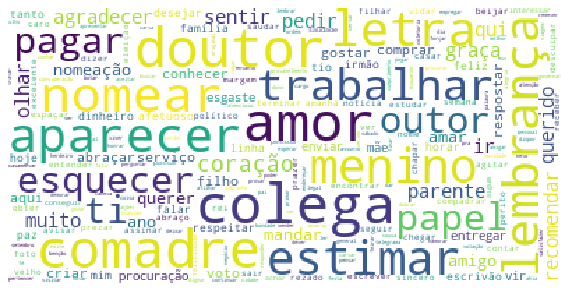

In [120]:
texto = ' '.join(todos)

# Gera a nuvem de palavras
wordcloud = WordCloud().generate(texto)

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",
                      max_words=len(todos),
                      max_font_size=40, 
                      relative_scaling=.6) \
            .generate(texto)

plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

for i in range(5):
    printmd('<br/><font color="gray"><u>**Tópicos ' + str(i+1) + ' e ' + str(i+2) + ':**</u></font>')
    
    printmd('**Tokens apenas no tópico ' + str(i+1) + ':**')
    print(set(palavras[i])-set(palavras[i+1]))

    printmd('**Tokens nos dois tópicos:**')
    print(set(palavras[i+1])-set(palavras[i]))

    printmd('**Tokens apenas no tópico ' + str(i+2) + ':**')
    print(set(palavras[i]).intersection(palavras[i+1]))